In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_addons as tfa
import tensorflow.keras.layers as kl
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses 
from tensorflow.keras import metrics as kmetrics
from sklearn import metrics as skmetrics
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from MulticoreTSNE import MulticoreTSNE as TSNE
from IPython.display import clear_output

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from IPython import display
from datetime import datetime as dt

from data.utils import WindowDataset

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
plt.rcParams["figure.figsize"] = (16, 8)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   # Currently, memory growth needs to be the same across GPUs
   try:
       for gpu in gpus:
           tf.config.experimental.set_memory_growth(gpu, True)
   except RuntimeError as e:
       print(e)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), markerscale=4, fontsize=18)        

from matplotlib import cm
import matplotlib

color_nominal = matplotlib.colors.to_rgba('C2')
color_pga_leak = matplotlib.colors.to_rgba('C1')
color_fluid_leak = matplotlib.colors.to_rgba('C0')
color_cooler_fault = matplotlib.colors.to_rgba('C4')
color_valve_error = matplotlib.colors.to_rgba('C3')

class_colors = np.array([color_nominal, color_cooler_fault, color_valve_error, color_fluid_leak, color_pga_leak]) 
    
%matplotlib inline

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Parameters

In [3]:
data_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_DATA_PATH']
models_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_MODELS_PATH']

class Bunch:
    __init__ = lambda self, **kw: setattr(self, '__dict__', kw)
args = Bunch()    

args.window_size = 5000
args.train_test_split_ratio = 0.9
args.portion = 1.0
args.batch_size = 2**7
args.epochs = 100
args.windows_per_epoch = int(1e6)
args.active_channels = 17
args.initial_learning_rate = 3e-4
args.decay = args.initial_learning_rate / args.epochs
args.warmup_steps = 1

model_name = 'GCAEC_zema_5states_10sec'
dataset_path = '../data/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA/condition_monitoring_of_hydraulic_systems_data_set_at_ZeMA_multiclass.csv'

now = dt.now()
log_name = '{}_epochs_{}_{}_{}_{}.h5'.format(model_name, args.epochs, now.day, now.hour, now.minute)
hist_log_name = '{}_epochs_{}_{}_{}_{}.csv'.format(model_name, args.epochs, now.day, now.hour, now.minute)

In [4]:
def noam_based_decay(epoch, lr):
    epoch += 1    
    return args.initial_learning_rate * args.warmup_steps**0.5 * min(epoch**-0.5, epoch*(args.warmup_steps**-1.5)) 

# Dataset

In [5]:
dataset_description = pd.read_csv(dataset_path, skipinitialspace=True)
dataset_description

fp  cid                      name
0    sensors_numpy/record_1664.npy    0                 Исправная
1    sensors_numpy/record_1665.npy    0                 Исправная
2    sensors_numpy/record_1666.npy    0                 Исправная
3    sensors_numpy/record_1667.npy    0                 Исправная
4    sensors_numpy/record_1668.npy    0                 Исправная
..                             ...  ...                       ...
582  sensors_numpy/record_2200.npy    4  Утечка газа аккумулятора
583  sensors_numpy/record_2201.npy    4  Утечка газа аккумулятора
584  sensors_numpy/record_2202.npy    4  Утечка газа аккумулятора
585  sensors_numpy/record_2203.npy    4  Утечка газа аккумулятора
586  sensors_numpy/record_2204.npy    4  Утечка газа аккумулятора

[587 rows x 3 columns]

In [6]:
X = WindowDataset(dataset_path, window_size=args.window_size, initial_shuffle=True, portion=args.portion, active_channels=args.active_channels, verbose=False)

In [7]:
X_train = X.get_generator(
    get_item=lambda cid, w: (w.T, (w.T, cid, cid)),
    get_types=lambda: (tf.float32, (tf.float32, tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([args.window_size, args.active_channels]), tf.TensorShape([]), tf.TensorShape([]))),
    train=True, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio)

X_test = X.get_generator(
    get_item=lambda cid, w: (w.T, (w.T, cid, cid)),
    get_types=lambda: (tf.float32, (tf.float32, tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([args.window_size, args.active_channels]), tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio)

In [8]:
X_test_classifier, test_labels_true = X.get_generator(
    get_item=lambda cid, w: (w.T, ( cid, cid)),
    get_types=lambda: (tf.float32, ( tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  ( tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio,
    return_true_labels=True)

# Model

In [9]:
input_shape = (X.window_size, X.active_channels)
embedding_size = 2
units = 32
kernel_size = 3

conv_num = -1
def conv_block_name():
    global conv_num
    conv_num = conv_num + 1
    return 'cb_{}'.format(conv_num)

def conv_block(output_timesteps, output_channels, name):
    def f(preceding_layer):
        input_timesteps, input_channels = preceding_layer.get_shape().as_list()[1:]
        
        inputs = k.Input(shape=(input_timesteps, input_channels))
               
        act = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='linear', padding='same', name=name+'_conv_features1')(inputs)
        gate = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='sigmoid', padding='same', name=name+'_conv_memory')(inputs)
        gated_act = kl.Multiply()([tfa.layers.InstanceNormalization()(kl.PReLU()(act)), gate]) 
               
        a = kl.Permute((2,1))(gated_act)
        b = kl.Dense(output_timesteps)(a)
        c = kl.Permute((2,1))(b)
        
        m = k.Model(inputs=inputs, outputs=[c, gate], name=name)
#         m.summary()
        return m(preceding_layer)
    return f

inputs = k.Input(shape=input_shape)

e, g1 = conv_block(output_timesteps=100, output_channels=units, name=conv_block_name())(inputs)
e, g2 = conv_block(output_timesteps=50, output_channels=units, name=conv_block_name())(e)
e, g3 = conv_block(output_timesteps=25, output_channels=units, name=conv_block_name())(e)
e, g4 = conv_block(output_timesteps=10, output_channels=units, name=conv_block_name())(e)

d, g5 = conv_block(output_timesteps=25, output_channels=units, name=conv_block_name())(e)
d, g6 = conv_block(output_timesteps=50, output_channels=units, name=conv_block_name())(d)
d, g7 = conv_block(output_timesteps=100, output_channels=units, name=conv_block_name())(d)
d, g8 = conv_block(output_timesteps=X.window_size, output_channels=X.active_channels, name='decoder_output')(d)

decoder_output = d

ef = kl.Flatten()(e)
embedding_output = kl.Dense(embedding_size, activation='linear', name='emb')(ef)
softmax_output = kl.Dense(X.number_of_classes, activation='softmax', name='softmax_layer')(embedding_output)
label_output = kl.Lambda(lambda x: k.backend.argmax(x), name='label_layer')(softmax_output)

autoencoder_model = k.Model(inputs=inputs, outputs=[decoder_output, softmax_output, label_output], name='autoencoder')
encoder_model = k.Model(inputs=inputs, outputs=embedding_output, name='encoder')
classifier_model = k.Model(inputs=inputs, outputs=[softmax_output, label_output], name='classifier')

autoencoder_model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000, 17)]   0                                            
__________________________________________________________________________________________________
cb_0 (Functional)               [(None, 100, 32), (N 663492      input_1[0][0]                    
__________________________________________________________________________________________________
cb_1 (Functional)               [(None, 50, 32), (No 14522       cb_0[0][0]                       
__________________________________________________________________________________________________
cb_2 (Functional)               [(None, 25, 32), (No 9147        cb_1[0][0]                       
________________________________________________________________________________________

# Train

In [10]:
class History:
    def __init__(self, path):
        self.path = path
        self.train_loss = []
        self.train_ae_loss = []
        self.train_classifier_loss = []
        self.train_classifier_acc = []
        
        self.test_loss = []
        self.test_ae_loss = []
        self.test_classifier_loss = []
        self.test_classifier_acc = []

        
    def save_state(self):
        df = pd.DataFrame({i:d[i] for i in self.__dict__ if i != 'path'})
        df.to_csv(self.path, index=False)
    
    def load_state(self):
        df = pd.read_csv(self.path)
        for c in df.columns:
            self.__dict__[c] = df[c].to_list()
        
history = History(hist_log_name)

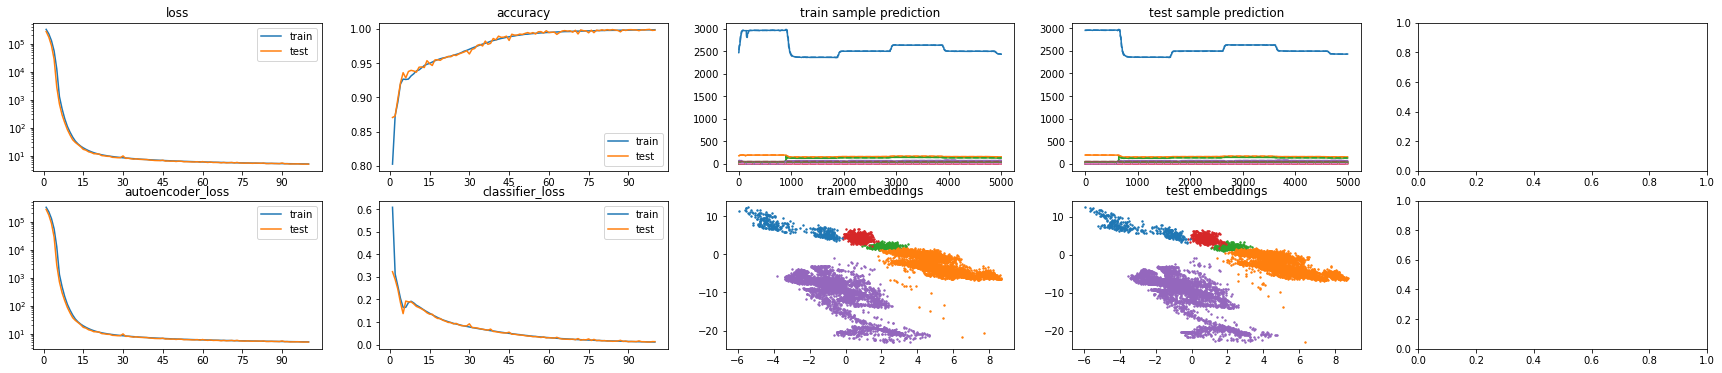

13:28:54.189926 100/100
train_loss: 5.0425096, test_loss:4.9682264
train_acc: 99.88, test_acc:99.81
train_ae_loss: 5.0312939, test_ae_loss:4.9552183
CPU times: user 10h 39min 53s, sys: 3h 29min 18s, total: 14h 9min 12s
Wall time: 13h 28min 54s


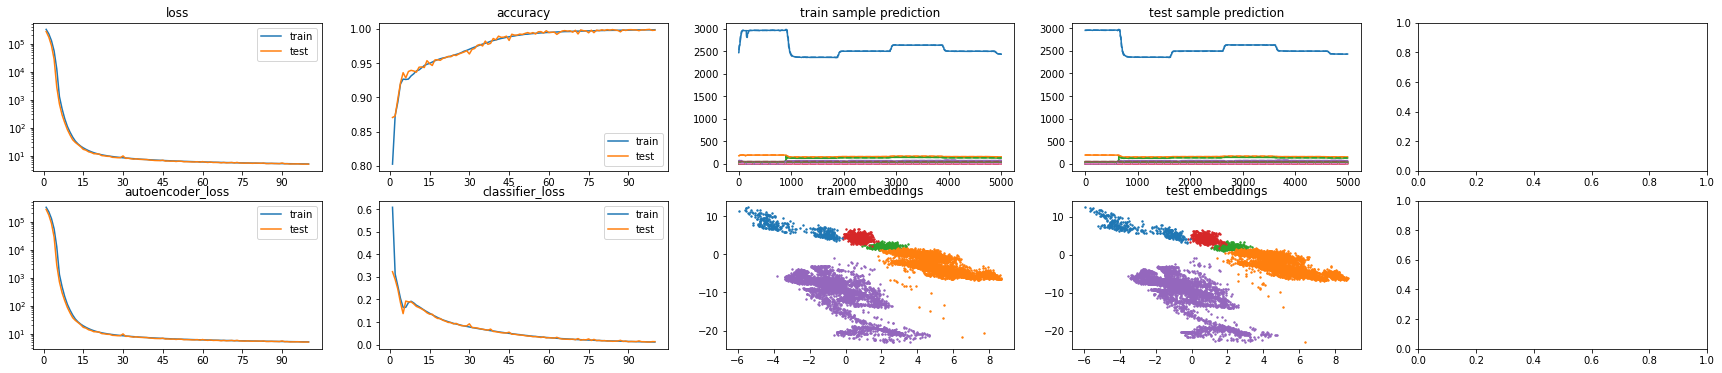

In [11]:
%%time 

start_time = dt.now()

fig, [[ax1, ax2, ax3, ax4, ax5], [ax10, ax20, ax30, ax40, ax50]] = plt.subplots(2,5, figsize=(30,6), gridspec_kw={'width_ratios':[0.2, 0.2, 0.2, 0.2, 0.2]})

# samples = max(10000, int(X.number_of_windows*0.1))
samples = 10000

callbacks = []
class DrawingCallback(k.callbacks.Callback):
    def __init__(self, history):
        self.history = history
        self.train_sample = X_train.take(samples)
        self.test_sample = X_test.take(samples)
        self.train_sample_1 = list(X_train.take(1).as_numpy_iterator())[0][0]
        self.test_sample_1 = list(X_test.take(1).as_numpy_iterator())[0][0]
    
    def on_epoch_end(self, epoch, logs={}):
        train_results = logs
        train_loss, train_ae_loss, train_classifier_loss, train_classifier_acc = train_results['loss'], train_results['decoder_output_loss'], train_results['softmax_layer_loss'], train_results['softmax_layer_sparse_categorical_accuracy']
        
        test_results = autoencoder_model.evaluate(self.test_sample.batch(args.batch_size), return_dict=True)
        test_loss, test_ae_loss, test_classifier_loss, test_classifier_acc = test_results['loss'], test_results['decoder_output_loss'], test_results['softmax_layer_loss'], test_results['softmax_layer_sparse_categorical_accuracy']
        
        predicted_train, _, _ = autoencoder_model.predict(self.train_sample_1[np.newaxis])
        predicted_test, _, _ = autoencoder_model.predict(self.test_sample_1[np.newaxis])
        predicted_train_z = encoder_model.predict(self.train_sample.batch(args.batch_size))
        predicted_test_z = encoder_model.predict(self.test_sample.batch(args.batch_size))
        
        self.history.train_loss.append(train_loss)
        self.history.train_ae_loss.append(train_ae_loss)
        self.history.train_classifier_loss.append(train_classifier_loss)
        self.history.train_classifier_acc.append(train_classifier_acc)
        self.history.test_loss.append(test_loss)
        self.history.test_ae_loss.append(test_ae_loss)
        self.history.test_classifier_loss.append(test_classifier_loss)
        self.history.test_classifier_acc.append(test_classifier_acc)
               
        ax1.cla()
        ax2.cla()
        ax3.cla()
        ax4.cla()
        ax5.cla()
        ax10.cla()
        ax20.cla()
        ax30.cla()
        ax40.cla()
        ax50.cla()
        
        ax1.set_title("loss")
        ax10.set_title("autoencoder_loss")
        ax20.set_title("classifier_loss")
        ax2.set_title("accuracy")
        
        ax1.set_yscale('log')
        ax10.set_yscale('log')
        
        ax3.set_title("train sample prediction")
        ax4.set_title("test sample prediction")
        ax30.set_title("train embeddings")
        ax40.set_title("test embeddings")

        ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax1.plot(range(1, len(self.history.train_loss)+1), self.history.train_loss, label='train')
        ax1.plot(range(1, len(self.history.test_loss)+1), self.history.test_loss, label='test')
        ax1.legend()        
    
        ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax2.plot(range(1, len(self.history.train_classifier_acc)+1), self.history.train_classifier_acc, label='train')
        ax2.plot(range(1, len(self.history.test_classifier_acc)+1), self.history.test_classifier_acc, label='test')
        ax2.legend()
        
        ax10.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax10.plot(range(1, len(self.history.train_ae_loss)+1), self.history.train_ae_loss, label='train')
        ax10.plot(range(1, len(self.history.test_ae_loss)+1), self.history.test_ae_loss, label='test')
        ax10.legend()
        
        ax20.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax20.plot(range(1, len(self.history.train_classifier_loss)+1), self.history.train_classifier_loss, label='train')
        ax20.plot(range(1, len(self.history.test_classifier_loss)+1), self.history.test_classifier_loss, label='test')
        ax20.legend()
        
        Xtrain_sample = self.train_sample_1 
        ax3.plot(Xtrain_sample, label='true')
        ax3.set_prop_cycle(None)
        ax3.plot(predicted_train[0], label='predicted', linestyle='dashed')
#         ax3.legend()
        
        Xtest_sample = self.test_sample_1
        ax4.plot(Xtest_sample, label='true')
        ax4.set_prop_cycle(None)
        ax4.plot(predicted_test[0], label='predicted', linestyle='dashed')
#         ax4.legend()
        

#         def legend_without_duplicate_labels(ax):
#             handles, labels = ax.get_legend_handles_labels()
#             unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#             ax.legend(*zip(*unique))

        for i in range(X.number_of_source_files):
            x = predicted_train_z[np.arange(samples)%X.number_of_source_files==i,0]
            y = predicted_train_z[np.arange(samples)%X.number_of_source_files==i,1]
            class_label = X.timeseries_class_labels[i]
            class_name = X.class_names[class_label]
            class_color = class_colors[class_label]
            ax30.scatter(x, y, s=2, label=class_name, color=class_color)       
            
#         ax30.legend()
        
#         legend_without_duplicate_labels(ax30)
        
        for i in range(X.number_of_source_files):
            x = predicted_test_z[np.arange(samples)%X.number_of_source_files==i,0]
            y = predicted_test_z[np.arange(samples)%X.number_of_source_files==i,1]
            class_label = X.timeseries_class_labels[i]
            class_name = X.class_names[class_label]
            class_color = class_colors[class_label]
            ax40.scatter(x, y, s=2, label=class_name, color=class_color)       

#         ax40.legend()
#         legend_without_duplicate_labels(ax40)

        display.clear_output(wait=True)
        display.display(fig)
        print("{} {}/{}".format(dt.now()-start_time, epoch+1, args.epochs))
        print("train_loss: {:.7f}, test_loss:{:.7f}".format(self.history.train_loss[-1], self.history.test_loss[-1]))
        print("train_acc: {:.2f}, test_acc:{:.2f}".format(self.history.train_classifier_acc[-1]*100, self.history.test_classifier_acc[-1]*100))
        print("train_ae_loss: {:.7f}, test_ae_loss:{:.7f}".format(self.history.train_ae_loss[-1], self.history.test_ae_loss[-1]))


callbacks.append(DrawingCallback(history))

tensorboard_logs_dir = os.environ['ENGINE_FAULT_DETECTION_PROJECT_LOGS_PATH'] + 'tensorboard/'

log_dir = tensorboard_logs_dir + log_name
callbacks.append(k.callbacks.TensorBoard(log_dir=log_dir + '', histogram_freq=1))

callbacks.append(k.callbacks.LearningRateScheduler(noam_based_decay, verbose=1))
opt = optimizers.Adam(learning_rate=args.initial_learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

autoencoder_model.compile(optimizer=opt, 
                          loss={'decoder_output':losses.MSE,
                                'softmax_layer':losses.SparseCategoricalCrossentropy()}, 
                          loss_weights={'decoder_output':1.0, 'softmax_layer':1.0, 'label_layer':0.0},
                          metrics={
                             'softmax_layer': kmetrics.SparseCategoricalAccuracy(),
                          }
                         )

autoencoder_model.fit(X_train.take(args.windows_per_epoch).batch(args.batch_size), epochs=args.epochs,  verbose=1, callbacks=callbacks)

In [ ]:
autoencoder_model.save(models_path + model_name + '_ae.h5')
encoder_model.save(models_path + model_name + '_e.h5')
classifier_model.save(models_path + model_name + '_c.h5')

# Test

In [12]:
%%time

test_probs_predicted, test_labels_predicted = classifier_model.predict(X_test_classifier.batch(args.batch_size))

CPU times: user 19.8 s, sys: 4.77 s, total: 24.6 s
Wall time: 25.2 s


In [24]:
test_accuracy = skmetrics.accuracy_score(test_labels_true, test_labels_predicted)
test_balanced_accuracy = skmetrics.balanced_accuracy_score(test_labels_true, test_labels_predicted)
test_precision = skmetrics.precision_score(test_labels_true, test_labels_predicted, average='macro')
test_recall = skmetrics.recall_score(test_labels_true, test_labels_predicted, average='macro')
test_f1 = skmetrics.f1_score(test_labels_true, test_labels_predicted, average='macro')
test_mcc = skmetrics.matthews_corrcoef(test_labels_true, test_labels_predicted)

In [25]:
metrics = pd.DataFrame([[test_accuracy*100, test_balanced_accuracy*100, test_precision, test_recall, test_f1, test_mcc]], 
                       columns=['accuracy', 'balanced_accuracy', 'precision (macro avg)', 'recall (macro avg)', 'f1 (macro avg)', 'MCC'],
                       index=['test'])
metrics

accuracy  balanced_accuracy  precision (macro avg)  recall (macro avg)  f1 (macro avg)       MCC
test  99.804342          99.483209               0.990794            0.994832        0.992787  0.996796

In [17]:
print(classification_report(test_labels_true, test_labels_predicted, target_names=X.class_names.values()))

                               precision    recall  f1-score   support

                    Исправная       0.96      0.99      0.97      2121
     Неисправность охлаждения       1.00      1.00      1.00     24442
Задержка срабатывания клапана       0.99      0.99      0.99      3030
     Утечка жидкости в насосе       1.00      1.00      1.00      2222
     Утечка газа аккумулятора       1.00      1.00      1.00     27472

                     accuracy                           1.00     59287
                    macro avg       0.99      0.99      0.99     59287
                 weighted avg       1.00      1.00      1.00     59287



Text(1.0, 1.0, 'Симуляционные данные\n\n                               precision    recall  f1-score   support\n\n                    Исправная       0.96      0.99      0.97      2121\n     Неисправность охлаждения       1.00      1.00      1.00     24442\nЗадержка срабатывания клапана       0.99      0.99      0.99      3030\n     Утечка жидкости в насосе       1.00      1.00      1.00      2222\n     Утечка газа аккумулятора       1.00      1.00      1.00     27472\n\n                     accuracy                           1.00     59287\n                    macro avg       0.99      0.99      0.99     59287\n                 weighted avg       1.00      1.00      1.00     59287\n')

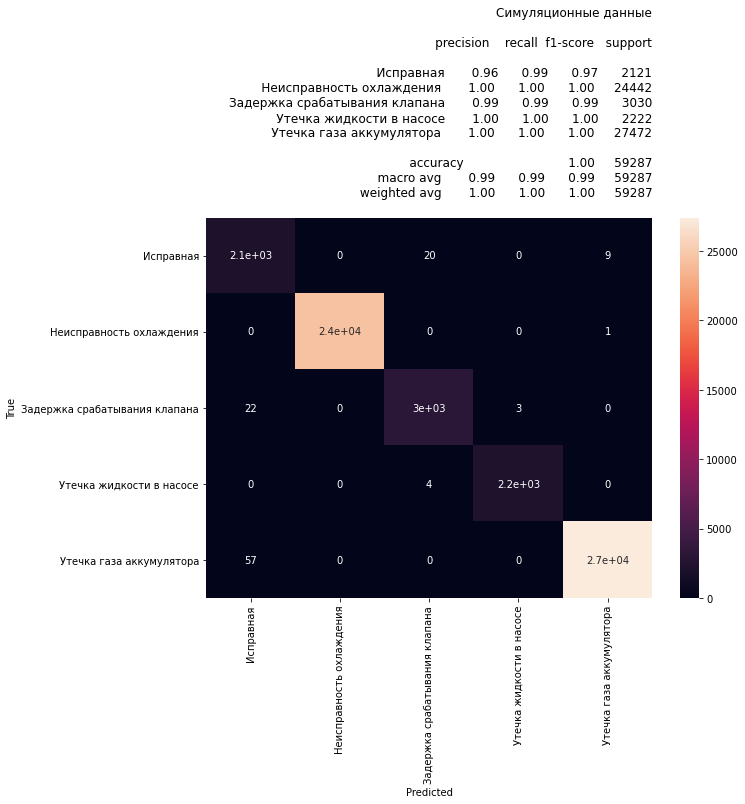

In [21]:
cf = confusion_matrix(test_labels_true, test_labels_predicted, normalize=None)

df_cm = pd.DataFrame(cf, index = X.class_names.values(), columns = X.class_names.values())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
plt.title("Симуляционные данные\n\n" + classification_report(test_labels_true, test_labels_predicted, target_names=X.class_names.values()), loc="right")

In [22]:
embeddings = encoder_model.predict(X_test_classifier.batch(args.batch_size))

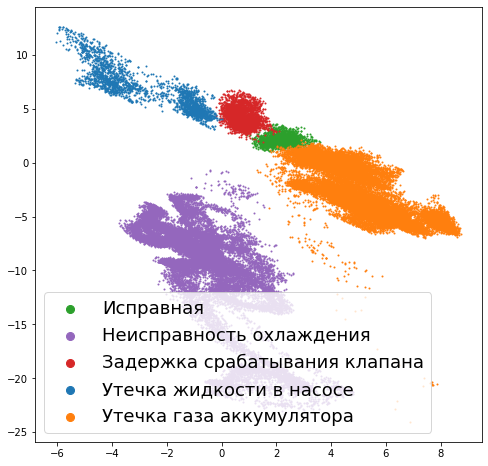

In [23]:
scale = 1
f, ax = plt.subplots(1,1, figsize=(8*scale, 8*scale))

for class_label, class_name, class_color in zip(X.class_names.keys(), X.class_names.values(), class_colors):
    x = embeddings[test_labels_true==class_label, 0]
    y = embeddings[test_labels_true==class_label, 1]    
    ax.scatter(x, y, s=1, label=class_name, color=class_color, alpha=1)       
    
ax.legend(loc='lower left', markerscale=8, fontsize=18);